# Starbucks Capstone Challenge

### Overview
This project is a real-life marketing strategy study based on simulated data set that mimics customer behavior on the Starbucks rewards mobile app. 

By analyzing transaction, demographic and offer data, we hope that we can better target offers towards customers with higher probability to use the offers. At the same time, customers receive personalized and relevant offers on the mobile app and get better user experience. By doing these, Starbucks could potentially maximize revenue and save on marketing and promotional costs.


### Problem Statement

The problems I am aiming to solve in this project are:
1. Discover the main drivers of offer effectiveness
2. Explore if we can predict whether a customer will respond to an offer.

I plan to accomplish the tasks by following the steps here:
1. Clean and preprocess the data: combine the offer portfolio, customer profile, and transaction data, generate label whether the customer responded to the offer or not.
2. Build classification models to predict whether a customer will respond to an offer or not. I use a DecisionTreeClassifer's performance as a baseline, comparing to random forest and gradient boosting models. Both accuracy and F1-score are used as performance metrics.
3. Refine the models by tuning parameters of the models.
4. Find the feature importance to identify the drivers of offer effectiveness



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


# Data Exloration

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio/Offer

#### Clean the data
1. Add a new column 'offer_id' that simplifies 'id' column.
2. One hot encode the 'channels' column


In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# simplify offer_id, id can be removed later on
offer_id =['B1', 'B2', 'I1', 'B3', 'D1', 'D2', 'D3', 'I2', 'B4', 'D4']
portfolio_clean = portfolio.copy()
portfolio_clean['offer_id'] = offer_id


In [4]:
#One hot encode the 'channels' column
portfolio_channels=portfolio_clean['channels'].str.join('|').str.get_dummies().add_prefix('channels_')
portfolio_clean = pd.concat([ portfolio_clean, portfolio_channels], axis=1)
portfolio_clean = portfolio_clean.drop(columns=['channels'])
portfolio_clean.head()

,difficulty,duration,id,offer_type,reward,offer_id,channels_email,channels_mobile,channels_social,channels_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,B1,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,B2,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,I1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,B3,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,D1,1,0,0,1


In [6]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids, 4 bogo, 4 discount types and 2 informational types.

### Profile/Demographic data

#### Clean the data
1. Remove the invalid rows
2. Convert became_member_on column from date  to tenure of the membership in days
3. Convert gender coloumn to categorical values


In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [41]:
profile_clean= profile.copy()

#1. remove the invalid rows which age is 118, gender is null, also income is null
profile_null = profile[(profile['age'] == 118) &(profile['income'].isnull()) & (profile['gender'].isnull())]
print(profile_null.shape[0]/profile.shape[0])

transcript_profile_null = transcript.merge(profile_null, left_on=['person'], right_on=['id'])
print(transcript_profile_null.shape[0]/transcript.shape[0])

profile_clean=profile_clean[profile_clean['income'].notnull()]

0.12794117647058822
0.11017374907840566


About 13% of the profile data do not have age, income or gender information. 11% of the transcript data are related to these profile. It's not significant amount of data and we will drop them.

In [42]:
import datetime
#2. became_member_on should be converted from dates to days, added membership_year
profile_clean['membership_days'] = profile_clean['became_member_on'].apply(lambda x: (datetime.datetime.today().date()-datetime.datetime.strptime(str(x), '%Y%m%d').date()))
profile_clean['membership_days'] = profile_clean['membership_days'].apply(lambda x: int((str(x).split())[0]))
profile_clean['membership_year'] = profile_clean['became_member_on'].apply(lambda x: int(str(x)[0:4]))
profile_clean.drop(['became_member_on'], axis=1,inplace=True)

profile_clean.head()

,age,gender,id,income,membership_days,membership_year
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,850,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,565,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,641,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,731,2017


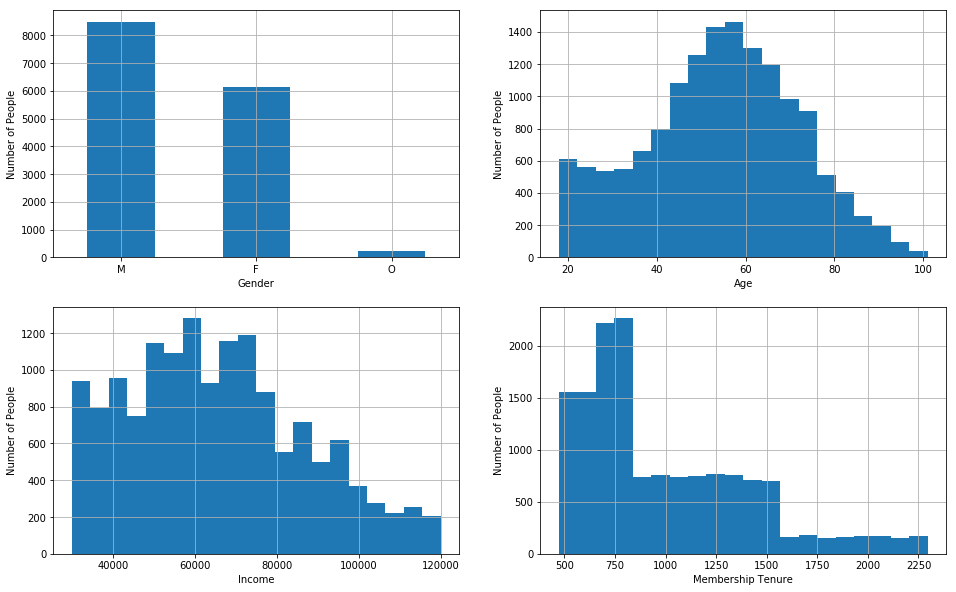

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

plt.subplot(221)
profile_clean.gender.value_counts().plot(kind='bar', rot=0);
plt.ylabel('Number of People');
plt.xlabel('Gender');
plt.grid();

plt.subplot(222)
plt.hist(profile_clean['age'], 20)
plt.ylabel('Number of People');
plt.xlabel('Age');
plt.grid()

plt.subplot(223)
plt.hist(profile_clean['income'], 20)
plt.ylabel('Number of People');
plt.xlabel('Income');
plt.grid()

plt.subplot(224)
plt.hist(profile_clean['membership_days'], 20)
plt.ylabel('Number of People');
plt.xlabel('Membership Tenure');
plt.grid()



Population distributions by gender, income, age, membership tenure. There are significantly more males than females. Both the income and the age distribution seem to approach a normal distribution. There are significantly more members who joined in the recent two years.

### Transaction data
#### Clean the data
1. Expand the value column to three columns
2. Merge offer id columns


In [6]:
#1. Expand the value column to three columns
transacript_temp = transcript.copy()
transcript_clean = pd.concat([transacript_temp, transacript_temp['value'].apply(pd.Series)], axis=1)
print(transcript_clean.iloc[0])


event                                         offer received
person                      78afa995795e4d85b5d9ceeca43f5fef
time                                                       0
value       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
offer id                    9b98b8c7a33c4b65b9aebfe6a799e6d9
amount                                                   NaN
offer_id                                                 NaN
reward                                                   NaN
Name: 0, dtype: object


In [42]:
transcript_clean.to_csv('data/transcript_clean.csv')

In [43]:
transcript_clean = pd.read_csv('data/transcript_clean.csv')


In [44]:
#2. #merge offer_id column
transcript_clean['offer_id_new']=np.where(transcript_clean['offer id'].isnull() & transcript_clean['offer_id'].notnull(),transcript_clean['offer_id'],transcript_clean['offer id'])
transcript_clean.drop(['offer id','offer_id'],axis=1,inplace=True)
transcript_clean.rename(columns={'offer_id_new':'offer_id'},inplace=True)
transcript_clean.drop(['value'], axis=1,inplace=True)
print(transcript_clean.iloc[0])




Unnamed: 0                                   0
event                           offer received
person        78afa995795e4d85b5d9ceeca43f5fef
time                                         0
amount                                     NaN
reward                                     NaN
offer_id      9b98b8c7a33c4b65b9aebfe6a799e6d9
Name: 0, dtype: object


### Merge Profile, Portfolio and Transaction Data

1. Ttranscript merge with portfolio
2. Merge with profile
3. Sort by person_id and event_time


In [45]:
#1. merge transcript and portfolio, join with offer_id
transcript_portfolio = transcript_clean.merge(portfolio_clean, left_on=['offer_id'], right_on = ['id'], how='left')
transcript_portfolio.drop(['offer_id_x', 'id'], axis=1,inplace=True)
transcript_portfolio.rename(columns={'offer_id_y':'offer_id', 'reward_x': 'transaction_reward', 'reward_y': 'offer_reward'},inplace=True)
print(transcript_portfolio.iloc[0])

Unnamed: 0                                           0
event                                   offer received
person                78afa995795e4d85b5d9ceeca43f5fef
time                                                 0
amount                                             NaN
transaction_reward                                 NaN
difficulty                                           5
duration                                             7
offer_type                                        bogo
offer_reward                                         5
offer_id                                            B3
channels_email                                       1
channels_mobile                                      1
channels_social                                      0
channels_web                                         1
Name: 0, dtype: object


In [46]:
#2. merge with profile, join with person
transcript_merged = transcript_portfolio.merge(profile_clean, left_on=['person'], right_on = ['id'])
print(transcript_merged.shape[0]) 
print(transcript_merged.iloc[0]) 


272762
Unnamed: 0                                           0
event                                   offer received
person                78afa995795e4d85b5d9ceeca43f5fef
time                                                 0
amount                                             NaN
transaction_reward                                 NaN
difficulty                                           5
duration                                             7
offer_type                                        bogo
offer_reward                                         5
offer_id                                            B3
channels_email                                       1
channels_mobile                                      1
channels_social                                      0
channels_web                                         1
age                                                 75
gender                                               F
id                    78afa995795e4d85b5d9ceeca43f5fef
inc

In [48]:
transcript_merged.rename(columns={'person':'person_id'},inplace=True)
transcript_merged.rename(columns={'time':'event_time'},inplace=True)
transcript_merged.sort_values(['person_id','event_time'])
transcript_merged.head()

,Unnamed: 0,event,person_id,event_time,amount,transaction_reward,difficulty,duration,offer_type,offer_reward,...,channels_email,channels_mobile,channels_social,channels_web,age,gender,id,income,membership_days,membership_year
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,5.0,7.0,bogo,5.0,...,1.0,1.0,0.0,1.0,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017
1,15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,5.0,7.0,bogo,5.0,...,1.0,1.0,0.0,1.0,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017
2,47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017
3,47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,5.0,7.0,bogo,5.0,...,1.0,1.0,0.0,1.0,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017
4,49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017


In [70]:
person_amount = pd.DataFrame()

person_amount['amount_total'] = transcript_merged[transcript_merged['event']=='transaction'].groupby(['person_id'])['amount'].sum()
person_amount['amount_per_transaction'] = transcript_merged[transcript_merged['event']=='transaction'].groupby(['person_id'])['amount'].mean()
person_amount = profile_clean.merge(person_amount, left_on=['id'], right_on = ['person_id'])
person_amount['amount_yearly'] = person_amount['amount_total']*365/person_amount['membership_days']
person_amount.head()



,age,gender,id,income,membership_days,membership_year,amount_total,amount_per_transaction
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,850,2017,77.01,25.670000
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,917,2017,159.27,22.752857
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,565,2018,57.73,19.243333
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,641,2018,36.43,12.143333
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,731,2017,15.62,3.905000


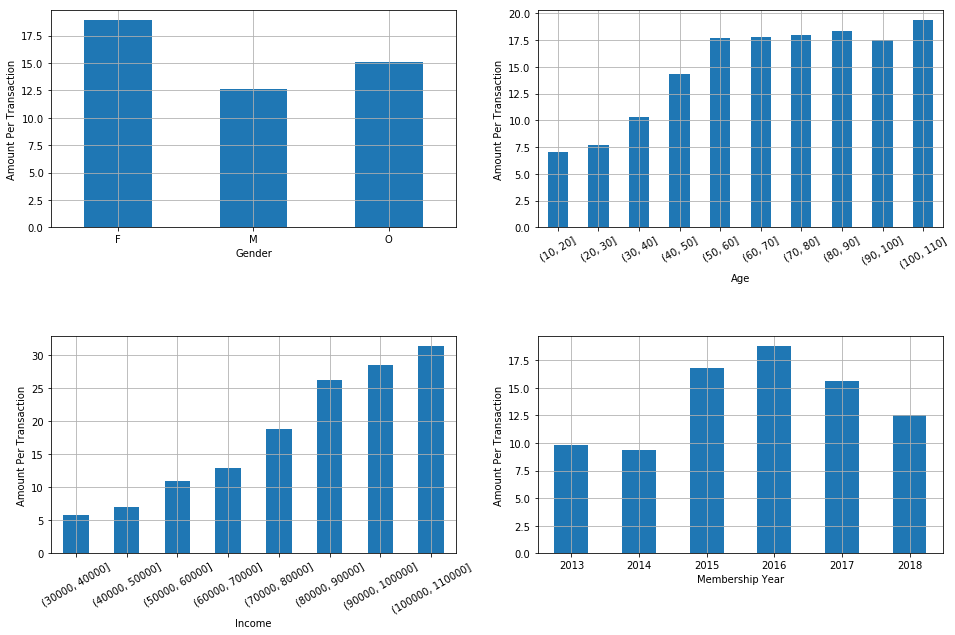

In [89]:

plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(221)
person_amount.groupby(['gender'])['amount_per_transaction'].mean().plot(kind='bar', rot=0);
plt.ylabel('Amount Per Transaction');
plt.xlabel('Gender');
plt.grid();

plt.subplot(222)
person_amount.groupby(pd.cut(person_amount["age"], np.arange(10, 120, 10)))['amount_per_transaction'].mean().plot(kind='bar', rot=30)
plt.ylabel('Amount Per Transaction');
plt.xlabel('Age');
plt.grid()

plt.subplot(223)
person_amount.groupby(pd.cut(person_amount["income"], np.arange(30000, 120000, 10000)))['amount_per_transaction'].mean().plot(kind='bar', rot=30)
plt.ylabel('Amount Per Transaction');
plt.xlabel('Income');
plt.grid()

plt.subplot(224)
person_amount.groupby(['membership_year'])['amount_per_transaction'].mean().plot(kind='bar', rot=0)

plt.ylabel('Amount Per Transaction');
plt.xlabel('Membership Year');
plt.grid()


By gender, women spend more money in general. Expenses and average transaction value grow as the income grows and age increases. People obtained membership in 2015-2017 spend the most. 

### Data Preprocessing

We would like to determine whether a person responds to an offer. Only a person who received, viewed and completed an offer is considered to be responsive. 

For each person in the profile, We will loop through all his/her transactions to label whether that person is responsive or unresponsive to an offer. We also generate two additional columns: received_counts and responsive_counts which provides the total number of received offers per person and total number of responded offers per person.
    

In [305]:
def generate_person_offer_respond(person_id, transcript_merged):
    '''
    This function generates dataframe containing  offers each person received and that person's response.
    
    inputs: 
        person_id 
        transcript_merged - dataframe contains all the transactions.
    outputs:
        1. final_offer - a dataframe containing offers each person received and that person's response.
    
    '''


    person_transaction = transcript_merged[transcript_merged['person_id'] == person_id]


    responsive = 0
    reward = 0
    
    final_offer = pd.DataFrame(columns=['responsive', 'person_id', 'offer_id', 'offer_type', 'offer_reward',  
                  'difficulty',  'duration','age', 'gender', 'income', 'membership_days', 'membership_year', 'channels_email', 
                  'channels_mobile',  'channels_social',  'channels_web' ])
      
    # loop through transactions to label whether a person is responsive or unresponsive to an offer
    # 1. each received transaction generates a record
    # 2. for bogo and discount, only viewed and completed in the correct order, within valid period will be marked as responsive 
    # 3. for infomrational, only viewed and a transaction within valid period will be marked as responsive 

    for i in range(len(person_transaction)):
        if(person_transaction.iloc[i].event == 'offer received'):
            offer_id = person_transaction.iloc[i].offer_id
            offer_start_time = person_transaction.iloc[i].event_time
            offer_end_time = person_transaction.iloc[i].event_time + person_transaction.iloc[i].duration*24
            #print("received:", offer_id)


            #look for reviewed event
            reviewed_transaction = person_transaction[(person_transaction['event']== 'offer viewed') &\
                                (person_transaction['offer_id']==offer_id) &\
                               (person_transaction['event_time']>=offer_start_time) &\
                               (person_transaction['event_time']<=offer_end_time)]
            #print("reviewed:" , reviewed_transaction.shape[0])

            # need to differentiate different offer type

            if(reviewed_transaction.shape[0]>0):
                reviewed_time = reviewed_transaction.iloc[0].event_time

                if(person_transaction.iloc[i].offer_type == 'informational'):
                    completed_transaction = person_transaction[(person_transaction['event']== 'transaction') &\
                               (person_transaction['event_time']>=offer_start_time) &\
                               (person_transaction['event_time']<=offer_end_time)&\
                                (person_transaction['event_time']>=reviewed_time)]
                else :
                    completed_transaction = person_transaction[(person_transaction['event']== 'offer completed') &\
                                (person_transaction['offer_id']==offer_id) &\
                               (person_transaction['event_time']>=offer_start_time) &\
                               (person_transaction['event_time']<=offer_end_time)&\
                                (person_transaction['event_time']>=reviewed_time)]

                #print("complete:", completed_transaction.shape[0])

                if(completed_transaction.shape[0]>0):
                    responsive = 1
                    #print("completed transaction found.")

            final_offer = final_offer.append({'responsive':responsive, 'person_id':person_transaction.iloc[i].person_id, 'offer_id': offer_id, 
                            'offer_type': person_transaction.iloc[i].offer_type, 'offer_reward': person_transaction.iloc[i].offer_reward,
                            'difficulty': person_transaction.iloc[i].difficulty, 'duration': person_transaction.iloc[i].duration,
                            'age': person_transaction.iloc[i].age, 'gender': person_transaction.iloc[i].gender,
                            'income': person_transaction.iloc[i].income,'membership_days': person_transaction.iloc[i].membership_days, 'membership_year': person_transaction.iloc[i].membership_year,
                            'channels_email': person_transaction.iloc[i].channels_email, 'channels_mobile':person_transaction.iloc[i].channels_mobile,
                            'channels_social': person_transaction.iloc[i].channels_social,'channels_web': person_transaction.iloc[i].channels_web}, ignore_index=True)

            responsive = 0


    received_count = final_offer.groupby(['person_id','offer_id']).size().reset_index(name='received_counts')
    responsive_count = final_offer[final_offer['responsive']==1].groupby(['person_id','offer_id']).size().reset_index(name='responsive_counts')
    nonresponsive_count = final_offer[final_offer['responsive']==0].groupby(['person_id','offer_id']).size().reset_index(name='nonresponsive_counts')
    
    if(final_offer.shape[0]>0):
        final_offer = final_offer.merge(received_count , left_on=['person_id', 'offer_id'], right_on = ['person_id', 'offer_id'], how='left').merge(responsive_count , left_on=['person_id', 'offer_id'], right_on = ['person_id', 'offer_id'], how='left').merge(nonresponsive_count , left_on=['person_id', 'offer_id'], right_on = ['person_id', 'offer_id'],how='left')
        final_offer['responsive_counts'].fillna(value=0, inplace=True)
        final_offer['nonresponsive_counts'].fillna(value=0, inplace=True)

    return final_offer
    

In [98]:
#4eab02d70ac241a8911502dc1954069d
#23d67a23296a485781e69c109a10a1cf
#389bc3fa690240e798340f5a15918d5c
#error: eb540099db834cf59001f83a4561aef3
person_offer = generate_person_offer_respond('389bc3fa690240e798340f5a15918d5c', transcript_merged)
print(person_offer)

  responsive                         person_id offer_id offer_type  \
0          1  389bc3fa690240e798340f5a15918d5c       B4       bogo   
1          0  389bc3fa690240e798340f5a15918d5c       B3       bogo   
2          1  389bc3fa690240e798340f5a15918d5c       D4   discount   
3          1  389bc3fa690240e798340f5a15918d5c       B3       bogo   
4          1  389bc3fa690240e798340f5a15918d5c       B4       bogo   
5          1  389bc3fa690240e798340f5a15918d5c       D3   discount   

   offer_reward  difficulty  duration age gender   income membership_days  \
0           5.0         5.0       5.0  65      M  53000.0             641   
1           5.0         5.0       7.0  65      M  53000.0             641   
2           2.0        10.0       7.0  65      M  53000.0             641   
3           5.0         5.0       7.0  65      M  53000.0             641   
4           5.0         5.0       5.0  65      M  53000.0             641   
5           2.0        10.0      10.0  65      

In [ ]:
#14825 persons in the transcript, generate offer_respond for all people

aggregated_offer_respond = pd.DataFrame()

for i in range(len(transcript_merged['person_id'].unique())):
    person_offer_respond = generate_person_offer_respond((transcript_merged['person_id'].unique())[i], transcript_merged)
    aggregated_offer_respond = pd.concat([aggregated_offer_respond, person_offer_respond])
    
aggregated_offer_respond.to_csv('data/aggregated_offer_respond.csv')


In [306]:
respond = pd.read_csv('data/aggregated_offer_respond.csv')
respond.head()

,Unnamed: 0,age,channels_email,channels_mobile,channels_social,channels_web,difficulty,duration,gender,income,membership_days,membership_year,nonresponsive_counts,offer_id,offer_reward,offer_type,person_id,received_counts,responsive,responsive_counts
0,0,75,1.0,1.0,0.0,1.0,5.0,7.0,F,100000.0,917,2017,0.0,B3,5.0,bogo,78afa995795e4d85b5d9ceeca43f5fef,1.0,1,1.0
1,1,75,1.0,1.0,1.0,0.0,0.0,3.0,F,100000.0,917,2017,0.0,I2,0.0,informational,78afa995795e4d85b5d9ceeca43f5fef,1.0,1,1.0
2,2,75,1.0,1.0,1.0,0.0,10.0,7.0,F,100000.0,917,2017,0.0,B1,10.0,bogo,78afa995795e4d85b5d9ceeca43f5fef,1.0,1,1.0
3,3,75,1.0,1.0,1.0,1.0,5.0,5.0,F,100000.0,917,2017,1.0,B4,5.0,bogo,78afa995795e4d85b5d9ceeca43f5fef,1.0,0,0.0
4,0,68,1.0,1.0,0.0,1.0,10.0,7.0,M,70000.0,565,2018,1.0,D4,2.0,discount,e2127556f4f64592b11af22de27a7932,1.0,0,0.0


Now we take a look at how offer reponse rate related to offer type and demographic features.

In [317]:
def generate_response_rate(grp_name):
    '''
    Generate dataframe of response rate to specified groups.
    
   '''
    respond_df = pd.DataFrame()
 
    if(grp_name == 'age'):
        respond_df['received_counts'] = respond.groupby(pd.cut(respond["age"], np.arange(10, 120, 10)))['received_counts'].sum()
        respond_df['responsive_counts'] = respond.groupby(pd.cut(respond["age"], np.arange(10, 120, 10)))['responsive_counts'].sum()
    elif(grp_name == 'income'):
        respond_df['received_counts'] = respond.groupby(pd.cut(respond["income"], np.arange(30000, 120000, 10000)))['received_counts'].sum()
        respond_df['responsive_counts'] = respond.groupby(pd.cut(respond["income"], np.arange(30000, 120000, 10000)))['responsive_counts'].sum()
    else:
        respond_df['received_counts'] = respond.groupby(grp_name)['received_counts'].sum()
        respond_df['responsive_counts'] = respond.groupby(grp_name)['responsive_counts'].sum()
   
    respond_df['responsive_rate'] = respond_df['responsive_counts']/respond_df['received_counts']
    
    return respond_df


In [318]:
respond_offer_type = generate_response_rate('offer_type')
respond_offer_type

,received_counts,responsive_counts,responsive_rate
offer_type,,,
bogo,36423.0,15014.0,0.412212
discount,36696.0,16662.0,0.454055
informational,18298.0,7275.0,0.397584


In [319]:
respond_age = generate_response_rate('age')
respond_age

,received_counts,responsive_counts,responsive_rate
age,,,
"(10, 20]",2068.0,689.0,0.333172
"(20, 30]",8466.0,2945.0,0.347862
"(30, 40]",9856.0,4006.0,0.406453
"(40, 50]",14668.0,6556.0,0.446959
"(50, 60]",22125.0,9758.0,0.441040
"(60, 70]",18094.0,7896.0,0.436388
"(70, 80]",10044.0,4339.0,0.431999
"(80, 90]",4703.0,2150.0,0.457155
"(90, 100]",1360.0,599.0,0.440441


In [320]:
respond_gender = generate_response_rate('gender')
respond_gender

,received_counts,responsive_counts,responsive_rate
gender,,,
F,37688.0,17670.0,0.468850
M,52487.0,20634.0,0.393126
O,1242.0,647.0,0.520934


In [321]:
respond_membership = generate_response_rate('membership_year')
respond_membership

,received_counts,responsive_counts,responsive_rate
membership_year,,,
2013,1680.0,745.0,0.443452
2014,4087.0,1815.0,0.444091
2015,9940.0,5234.0,0.526559
2016,18612.0,10554.0,0.567054
2017,34541.0,14455.0,0.418488
2018,22557.0,6148.0,0.272554


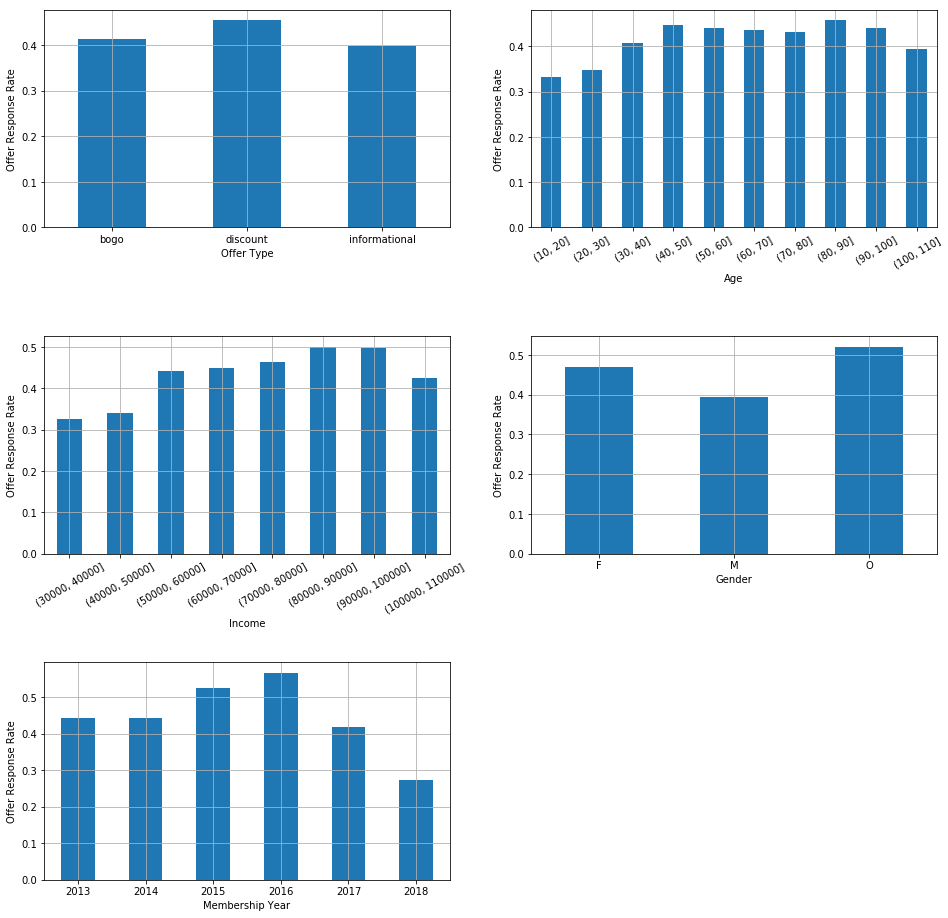

In [326]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(321)
respond_offer_type['responsive_rate'].plot(kind='bar', rot=0);
plt.ylabel('Offer Response Rate');
plt.xlabel('Offer Type');
plt.grid();

plt.subplot(322)
respond_age['responsive_rate'].plot(kind='bar', rot=30);
plt.ylabel('Offer Response Rate');
plt.xlabel('Age');
plt.grid()

plt.subplot(323)
respond_income['responsive_rate'].plot(kind='bar', rot=30);
plt.ylabel('Offer Response Rate');
plt.xlabel('Income');
plt.grid()

plt.subplot(324)
respond_gender['responsive_rate'].plot(kind='bar', rot=0);
plt.ylabel('Offer Response Rate');
plt.xlabel('Gender');
plt.grid()

plt.subplot(325)
respond_membership['responsive_rate'].plot(kind='bar', rot=0);
plt.ylabel('Offer Response Rate');
plt.xlabel('Membership Year');
plt.grid()

Discount type offer has the highest response rate. People who are over 30 have higher response rate than younger ones. People whose income are higher than 50,000 have higher response rate than lower income group. Female has higher response rate than maile. People who obtained membership in 2015 and 2016 have higher reposnse rate



In [327]:
respond_channels_email = generate_response_rate('channels_email')
respond_channels_email

,received_counts,responsive_counts,responsive_rate
channels_email,,,
1.0,91417.0,38951.0,0.42608


In [328]:
respond_channels_mobile = generate_response_rate('channels_mobile')
respond_channels_mobile

,received_counts,responsive_counts,responsive_rate
channels_mobile,,,
0.0,9238.0,1876.0,0.203074
1.0,82179.0,37075.0,0.451149


In [329]:
respond_channels_social = generate_response_rate('channels_social')
respond_channels_social

,received_counts,responsive_counts,responsive_rate
channels_social,,,
0.0,36781.0,10446.0,0.284005
1.0,54636.0,28505.0,0.521726


In [330]:
respond_channels_web = generate_response_rate('channels_web')
respond_channels_web

,received_counts,responsive_counts,responsive_rate
channels_web,,,
0.0,18314.0,8189.0,0.447144
1.0,73103.0,30762.0,0.420804


In [337]:
print(respond_channels_email.iloc[0].responsive_rate)

0.42608048831180195


In [341]:
response_channels = respond_channels_email.responsive_rate
rate_list =[['email', respond_channels_email.iloc[0].responsive_rate], \
            ['mobile', respond_channels_mobile.iloc[0].responsive_rate],\
            ['social', respond_channels_social.iloc[0].responsive_rate],\
            ['web', respond_channels_web.iloc[0].responsive_rate]]
#print(rate_list)
response_channels = pd.DataFrame(rate_list, columns=['channel','response_rate'])
response_channels

,channel,response_rate
0,email,0.426080
1,mobile,0.203074
2,social,0.284005
3,web,0.447144


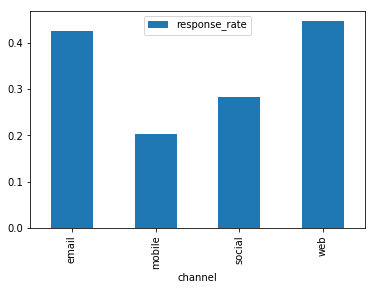

In [343]:
response_channels.plot(x='channel', y='response_rate', kind='bar')

Web and Email channels' response rate are much higher than mobile or social.

### Construct Models

We are ready to build a classification model that predicts whether a customer will respond to an offer or not. We have identified 14 features variables and 'responsive' as target variable.

In [344]:
#Import all useful packages
import datetime
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report

In [345]:
# gender will be converted to categorical values
respond['gender']=respond['gender'].apply(lambda x: 1 if x =='M' else (2 if x =='F' else 0))
# generate reponse_rate colum for each person, 
respond['response_rate'] = respond['responsive_counts']/respond['received_counts']
respond.head()

,Unnamed: 0,age,channels_email,channels_mobile,channels_social,channels_web,difficulty,duration,gender,income,...,membership_year,nonresponsive_counts,offer_id,offer_reward,offer_type,person_id,received_counts,responsive,responsive_counts,response_rate
0,0,75,1.0,1.0,0.0,1.0,5.0,7.0,2,100000.0,...,2017,0.0,B3,5.0,bogo,78afa995795e4d85b5d9ceeca43f5fef,1.0,1,1.0,1.0
1,1,75,1.0,1.0,1.0,0.0,0.0,3.0,2,100000.0,...,2017,0.0,I2,0.0,informational,78afa995795e4d85b5d9ceeca43f5fef,1.0,1,1.0,1.0
2,2,75,1.0,1.0,1.0,0.0,10.0,7.0,2,100000.0,...,2017,0.0,B1,10.0,bogo,78afa995795e4d85b5d9ceeca43f5fef,1.0,1,1.0,1.0
3,3,75,1.0,1.0,1.0,1.0,5.0,5.0,2,100000.0,...,2017,1.0,B4,5.0,bogo,78afa995795e4d85b5d9ceeca43f5fef,1.0,0,0.0,0.0
4,0,68,1.0,1.0,0.0,1.0,10.0,7.0,1,70000.0,...,2018,1.0,D4,2.0,discount,e2127556f4f64592b11af22de27a7932,1.0,0,0.0,0.0


In [354]:
#clean up before fit model
X= respond.copy()

X= pd.get_dummies(respond,columns=['gender'],dummy_na=True)
X.rename(columns={'gender_0.0':'gender_F', 'gender_1.0':'gender_M', 'gender_2.0':'gender_O'},inplace=True)

y = X['responsive']
X.drop(['responsive', 'person_id', 'offer_type', 'gender_nan', 'offer_id', 'received_counts', 'nonresponsive_counts', 'responsive_counts'],axis=1,inplace=True)
X.drop([X.columns[0]],axis=1,inplace=True)

df_response = X['response_rate']
X.drop(['response_rate'],axis=1,inplace=True)

X.head()

,age,channels_email,channels_mobile,channels_social,channels_web,difficulty,duration,income,membership_days,membership_year,offer_reward,gender_F,gender_M,gender_O
0,75,1.0,1.0,0.0,1.0,5.0,7.0,100000.0,917,2017,5.0,0,0,1
1,75,1.0,1.0,1.0,0.0,0.0,3.0,100000.0,917,2017,0.0,0,0,1
2,75,1.0,1.0,1.0,0.0,10.0,7.0,100000.0,917,2017,10.0,0,0,1
3,75,1.0,1.0,1.0,1.0,5.0,5.0,100000.0,917,2017,5.0,0,0,1
4,68,1.0,1.0,0.0,1.0,10.0,7.0,70000.0,565,2018,2.0,0,1,0


In [ ]:
# split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=40)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)

#scale test data
X_test=scaler.transform(X_test)

In [356]:
df= pd.DataFrame(X_test)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.750358,0.0,0.334029,0.819698,-1.997653,-1.389903,-1.590997,-0.572739,1.129076,-1.351366,-1.235975,-0.118949,-1.162216,1.196017
1,-0.599030,0.0,0.334029,0.819698,-1.997653,0.415122,0.226656,0.306082,-1.192878,1.147800,1.699655,-0.118949,0.860425,-0.836108
2,-0.368764,0.0,0.334029,0.819698,0.500587,0.415122,-0.682171,0.537351,-1.045226,1.147800,1.699655,-0.118949,0.860425,-0.836108
3,-1.635225,0.0,0.334029,0.819698,-1.997653,-1.389903,-1.590997,-0.618993,0.055023,0.314745,-1.235975,-0.118949,-1.162216,1.196017
4,-0.080932,0.0,0.334029,0.819698,-1.997653,-1.389903,-1.590997,1.971218,-1.128578,1.147800,-1.235975,-0.118949,-1.162216,1.196017


In [362]:
y_train.value_counts()

0    27683
1    20197
Name: responsive, dtype: int64

In [363]:
y_test.value_counts()

0    10676
1     7945
Name: responsive, dtype: int64

We can see that labels are somewhat imbalanced. 

We use DecisionTreeClassifier as our baseline for performance comparision. We construct a RandomForestClassifier and a GradientBoostingClassifier to see whether these models can perform better than DecisionTreeClassifier. 

In [351]:
from time import time
from sklearn.metrics import mean_squared_error
import os

model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [369]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the algorithm to be trained and predicted on
       - X_train: training set
       - y_train: training label
       - X_test: testing set
       - y_test: testing label
    '''
    
    results = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
  
    results=[model.__class__.__name__, format(model.score(X_train,y_train), '.4f'),\
            format(model.score(X_test,y_test), '.4f'), format(f1_score(y_test, y_pred), '.4f')]
    
    #print(classification_report(y_test, y_pred,digits=2))
    return results

In [352]:
def run_model(models):
    '''
    inputs:
    - models: list of models
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    results = pd.DataFrame(columns=['model_name', 'training_accuracy', 'test_accuracy', 'F1_score'])
    
    for index in range(len(models)):
        row = train_predict(models[index], X_train, y_train, X_test, y_test)
        results.loc[index]=row
        
    return results

In [370]:
results=run_model([DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()])
print(results)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                   model_name training_accuracy test_accuracy F1_score
0      DecisionTreeClassifier            0.9628        0.6299   0.5602
1      RandomForestClassifier            0.9453        0.6653   0.5810
2  GradientBoostingClassifier            0.6987        0.6943   0.5958


We can see that GradientBoostingClassifier has both higher accuracy and F1 score than RandomForestClassifier or DecisionTreeClassifier. 

For all three models, the F1 scores are lower than the accuracy which may due to the imbalance of classes. But the overall higher accuracy compared to F1 score indicates that the model is predicting the positive case more accurately compared to predicting the negative cases. We do not mind sending people more offers than they would like, we would rather not miss anyone who is likely to respond to an offer.

Also DecisionTreeClassifier and RandomForestClassifier are overfitting. They have very high accurancy on the training data but poor generliazation to test data. For GradientBoostingClassifier, train accuracy and test accuracy are very close. So it's very reasonable to choose GradientBoostingClassifier as the best classifier. 





### Tune the model

we conduct GridSearch on the GradientBoostingClassifier to find the best parameters.

In [368]:
from sklearn.externals import joblib
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [281]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
random_state = 400
scorer = make_scorer(fbeta_score, beta=0.5)

if os.path.exists(gb_model_path):
    gb_random = joblib.load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

    gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    gb_random.fit(X_train, y_train)

joblib.dump(gb_random.best_estimator_, './models/grid_gbc.pkl')


['./models/grid_gbc.pkl']

In [360]:
best_model=joblib.load('./models/grid_gbc.pkl')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
acc = f1_score(y_test, y_pred)
print("test score:", best_model.score(X_test,y_test))
print("f1_score:", acc)

test score: 0.6993716771387144
f1_score: 0.6151519318025575


The accuracy for the GradientBoostingClassifier increased slightly - from 69.43% to 69.93%, and the F1 score increased from 59.58% to 61.52%. There is not much performance increase by tuning the parameters.

### Feature Importance

One of the problems we are trying to solve is to discover the drivers of an effective offer. We can check the feature importances for the models.


In [374]:
def get_feature_importance(estimator):
    
    relative_importance = estimator.feature_importances_
    relative_importance = relative_importance / np.sum(relative_importance)
    variable_names = X.columns

    feature_importance = pd.DataFrame(list(zip(variable_names, relative_importance)), columns=['feature', 'relativeimportance'])

    feature_importance = feature_importance.sort_values('relativeimportance', ascending=False)
    feature_importance = feature_importance.reset_index(drop=True)

    return feature_importance



In [375]:
gb_feature = get_feature_importance(gb_random.best_estimator_)
print(gb_feature)

            feature  relativeimportance
0   membership_days            0.321820
1   channels_social            0.262155
2            income            0.128878
3      offer_reward            0.105483
4          duration            0.062094
5               age            0.040156
6        difficulty            0.024595
7          gender_M            0.022382
8      channels_web            0.018433
9   channels_mobile            0.007367
10         gender_O            0.003549
11         gender_F            0.002637
12  membership_year            0.000452
13   channels_email            0.000000


Text(0.5, 1.0, 'Gradient Boosting Estimated Feature Importance')

<Figure size 1152x1152 with 0 Axes>

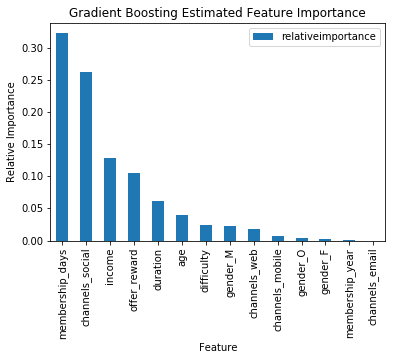

In [376]:
plt.figure(figsize=(16, 16))
gb_feature.plot(x='feature', y='relativeimportance', kind='bar')
plt.ylabel('Relative Importance')
plt.xlabel('Feature')
plt.title('Gradient Boosting Estimated Feature Importance')

In [379]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
dt_feature = get_feature_importance(model_dt)
print(dt_feature)

            feature  relativeimportance
0   membership_days            0.373830
1               age            0.219085
2            income            0.213461
3   channels_social            0.060653
4      offer_reward            0.036845
5          duration            0.021934
6        difficulty            0.021128
7          gender_M            0.017762
8          gender_O            0.014125
9   membership_year            0.009214
10     channels_web            0.008734
11         gender_F            0.002786
12  channels_mobile            0.000443
13   channels_email            0.000000


Looking at the feature importance, we can see that the most important feature in both models are the tenure of membership. I am not surprised to see Income is the 3rd important feature. I don't quite understand why the channels_social is the second important feature for GradientBoostingClassifier. In DecisionTreeClassifer, channels_social is the fourth, not much influence.

### Feature Engineering

When we preprocess the transaction data above, we have created  a new response_rate column. It's actually the success rate, i.e. the total number of responded offers divided by total number of received offers for each person. We will add this feature to the model and I believe it will largely increase the classifier's performance.  


In [384]:
X['response_rate'] = df_response

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=40)
X_train=scaler.fit_transform(X_train)

#scale test data
X_test=scaler.transform(X_test)


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [385]:
results=run_model([DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()])
print(results)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                   model_name training_accuracy test_accuracy F1_score
0      DecisionTreeClassifier            0.9628        0.9103   0.8941
1      RandomForestClassifier            0.9624        0.9118   0.8970
2  GradientBoostingClassifier            0.9524        0.9428   0.9336


Apparently that adding response rate feature drastically improves all models' performance. The accuracy for the GradientBoostingClassifier increased greatly - from 69.43% to 94.28%, and the F1 score increased from 59.58% to 93.36%. 

### Conclusion

In this project, through data exploration and model construction, I was able to solve the two problems stated at the beginning of the notebook.

1. Discover the main drivers of offer effectiveness:

I found that the tenure of a member is the biggest predictor of the effectiveness of an offer. Income is a big      one too. I am surprised that social channel is on the top 5 even though Web and Email channels' response rate are much higher than social.


2. Explore if we can predict whether a customer will respond to an offer:

I constructed one model to predict whether a customer will respond to an offer. I created a response_rate feature which greatly improves the classifier's performance. But the response_rate feature may not be available for new customers who has only demographical information and doesn't have much offer related transaction data. 


#### Future Enhancements:

1. I only constructed one model to predict whether a customer will respond to an offer. I could construct 3 different models for the 3 offer types: BOGO, Discount and Informational to get better results.


2. For convenience, I drop all the NaNs. In reality, there will be many missing data that we simply can not drop. In the future,I can use different techniques to fillna, such as using mean, median, etc.


3. Given more time and data, I could construct regression model  to predict how much someone will spend based on demographics and offer type


4. A predictor can be build so that when being provided with the customer information, the prediction of response/transaction amount can be made. Also a web application can be built using this predictor. 
